In [1]:
# !pip install ray[tune]
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from hyperopt import hp
from ray import tune
from hyperopt import fmin, tpe, hp,Trials, space_eval
import scipy.stats

c:\users\0x6f736f646f\onedrive\documents\nakuja\bmpdata\venv\lib\site-packages\ray\autoscaler\_private\cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


In [2]:
df = pd.read_csv("../../Data/Raw/flightLogData.csv")

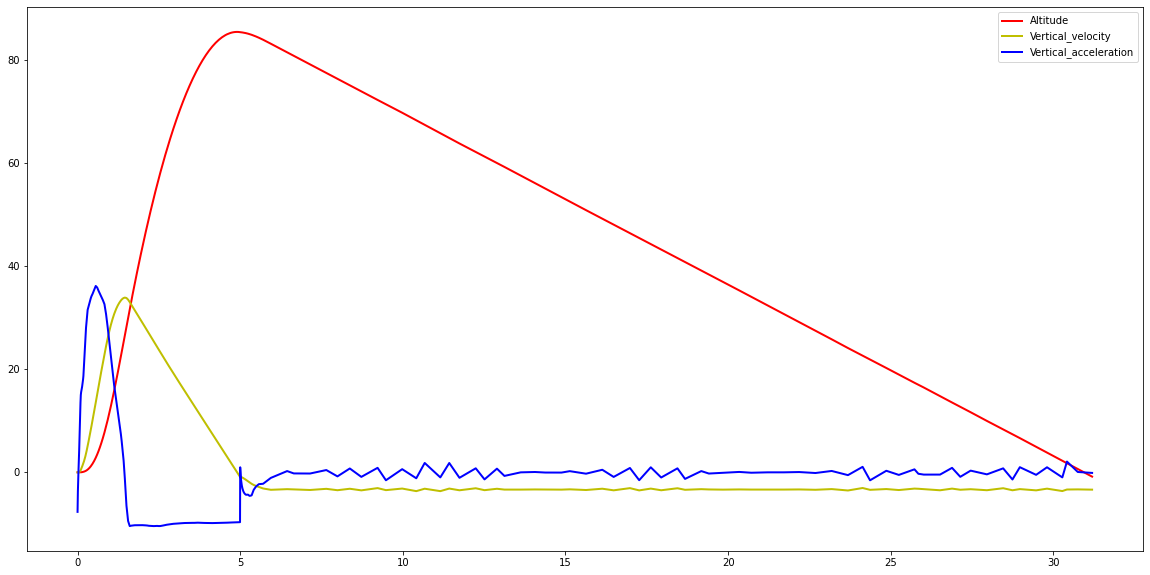

In [3]:
plt.figure(figsize=(20, 10))
plt.plot(df.Time, df['Altitude'],  linewidth=2, color="r", label="Altitude")
plt.plot(df.Time, df['Vertical_velocity'],  linewidth=2, color="y", label="Vertical_velocity")
plt.plot(df.Time, df['Vertical_acceleration'],  linewidth=2, color="b", label="Vertical_acceleration")
plt.legend()
plt.show()

In [4]:
temp_df = df[['Altitude', "Vertical_velocity", "Vertical_acceleration"]]
noise = np.random.normal(2, 5, temp_df.shape)
noisy_df = temp_df + noise
noisy_df['Time'] = df['Time']


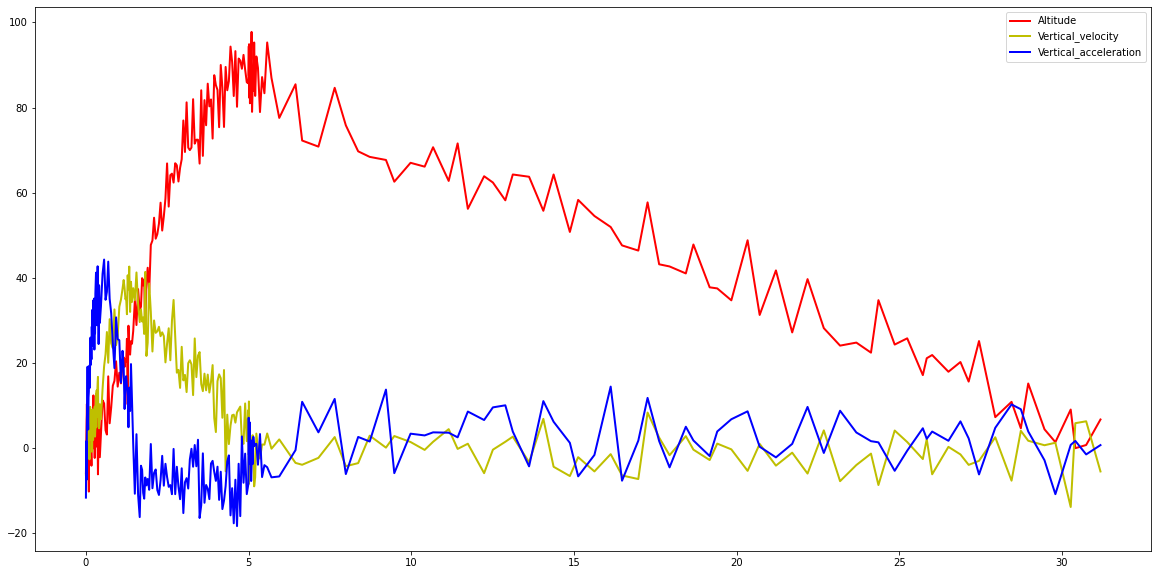

In [5]:
plt.figure(figsize=(20, 10))
plt.plot(noisy_df.Time, noisy_df['Altitude'],  linewidth=2, color="r", label="Altitude")
plt.plot(noisy_df.Time, noisy_df['Vertical_velocity'],  linewidth=2, color="y", label="Vertical_velocity")
plt.plot(noisy_df.Time, noisy_df['Vertical_acceleration'],  linewidth=2, color="b", label="Vertical_acceleration")
plt.legend()
plt.show()

## Altitude 

In [6]:
q = 0.001
A = np.array([[1.0, 0.1, 0.005], [0, 1.0, 0.1], [0, 0, 1]])
H = np.array([[1.0, 0.0, 0.0],[ 0.0, 0.0, 1.0]])
P = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
# R = np.array([[0.5, 0.0], [0.0, 0.0012]])
# Q = np.array([[q, 0.0, 0.0], [0.0, q, 0.0], [0.0, 0.0, q]])
I = np.identity(3)
x_hat = np.array([[0.0], [0.0], [0.0]])
Y = np.array([[0.0], [0.0]])

In [7]:
def kalman_update(param):
    r1, r2, q1 = param['r1'], param['r2'], param['q1']
    R = np.array([[r1, 0.0], [0.0, r2]])
    Q = np.array([[q1, 0.0, 0.0], [0.0, q1, 0.0], [0.0, 0.0, q1]])
    
    A = np.array([[1.0, 0.05, 0.00125], [0, 1.0, 0.05], [0, 0, 1]])
    H = np.array([[1.0, 0.0, 0.0],[ 0.0, 0.0, 1.0]])
    P = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    I = np.identity(3)
    x_hat = np.array([[0.0], [0.0], [0.0]])
    Y = np.array([[0.0], [0.0]])

    new_altitude = []
    new_acceleration = []
    new_velocity = []
    
    for altitude, az in zip(noisy_df['Altitude'], noisy_df['Vertical_acceleration']):
        Z = np.array([[altitude], [az]])

        x_hat_minus = np.dot(A, x_hat)
        P_minus = np.dot(np.dot(A, P), np.transpose(A)) + Q
        K  = np.dot(np.dot(P_minus, np.transpose(H)), np.linalg.inv((np.dot(np.dot(H, P_minus), np.transpose(H)) + R)))
        Y = Z - np.dot(H, x_hat_minus)
        x_hat = x_hat_minus + np.dot(K, Y)
        P = np.dot((I - np.dot(K, H)), P_minus)
        Y = Z - np.dot(H, x_hat_minus)
        new_altitude.append(float(x_hat[0]))
        new_velocity.append(float(x_hat[1]))
        new_acceleration.append(float(x_hat[2]))
    return new_altitude

In [8]:
def objective_function(param):
    r1, r2, q1 = param['r1'], param['r2'], param['q1']
    R = np.array([[r1, 0.0], [0.0, r2]])
    Q = np.array([[q1, 0.0, 0.0], [0.0, q1, 0.0], [0.0, 0.0, q1]])
    
    A = np.array([[1.0, 0.05, 0.00125], [0, 1.0, 0.05], [0, 0, 1]])
    H = np.array([[1.0, 0.0, 0.0],[ 0.0, 0.0, 1.0]])
    P = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    I = np.identity(3)
    x_hat = np.array([[0.0], [0.0], [0.0]])
    Y = np.array([[0.0], [0.0]])

    new_altitude = []
    new_acceleration = []
    new_velocity = []
    
    for altitude, az in zip(noisy_df['Altitude'], noisy_df['Vertical_acceleration']):
        Z = np.array([[altitude], [az]])

        x_hat_minus = np.dot(A, x_hat)
        P_minus = np.dot(np.dot(A, P), np.transpose(A)) + Q
        K  = np.dot(np.dot(P_minus, np.transpose(H)), np.linalg.inv((np.dot(np.dot(H, P_minus), np.transpose(H)) + R)))
        Y = Z - np.dot(H, x_hat_minus)
        x_hat = x_hat_minus + np.dot(K, Y)
        P = np.dot((I - np.dot(K, H)), P_minus)
        Y = Z - np.dot(H, x_hat_minus)
        new_altitude.append(float(x_hat[0]))
        new_velocity.append(float(x_hat[1]))
        new_acceleration.append(float(x_hat[2]))
    return mean_squared_error(df['Altitude'], new_altitude)

In [9]:
# space = {
#     "r1": hp.choice("r1", np.arange(0.01, 90, 0.005)),
#     "r2": hp.choice("r2", np.arange(0.01, 90, 0.005)),
#     "q1": hp.choice("q1", np.arange(0.0001, 0.0009, 0.0001))
# }

In [10]:
len(np.arange(0.00001, 0.09, 0.00001))

8999

In [11]:
space = {
    "r1": hp.choice("r1", np.arange(0.001, 90, 0.001)),
    "r2": hp.choice("r2", np.arange(0.001, 90, 0.001)),
    "q1": hp.choice("q1", np.arange(0.00001, 0.09, 0.00001))
}

In [12]:
# Initialize trials object
trials = Trials()

best = fmin(fn=objective_function, space = space, algo=tpe.suggest, max_evals=100, trials=trials )

100%|██████████████████████████████████████████████████████| 100/100 [47:29<00:00, 28.50s/trial, best loss: 13.195958595638682]


In [13]:
print(best)
# -> {'a': 1, 'c2': 0.01420615366247227}
print(space_eval(space, best))
# -> ('case 2', 0.01420615366247227}

{'q1': 8518, 'r1': 4718, 'r2': 56442}
{'q1': 0.08519, 'r1': 4.719, 'r2': 56.443}


In [14]:
d1 = space_eval(space, best)

In [15]:
objective_function(d1)

13.195958595638682

In [ ]:
%%timeit
objective_function({'q1': 0.0013, 'r1': 0.25, 'r2': 0.65})

In [16]:
objective_function({'q1': 0.0013, 'r1': 0.25, 'r2': 0.65})

28.025727827545634

In [17]:
y = kalman_update(d1)
current = kalman_update({'q1': 0.0013, 'r1': 0.25, 'r2': 0.65})

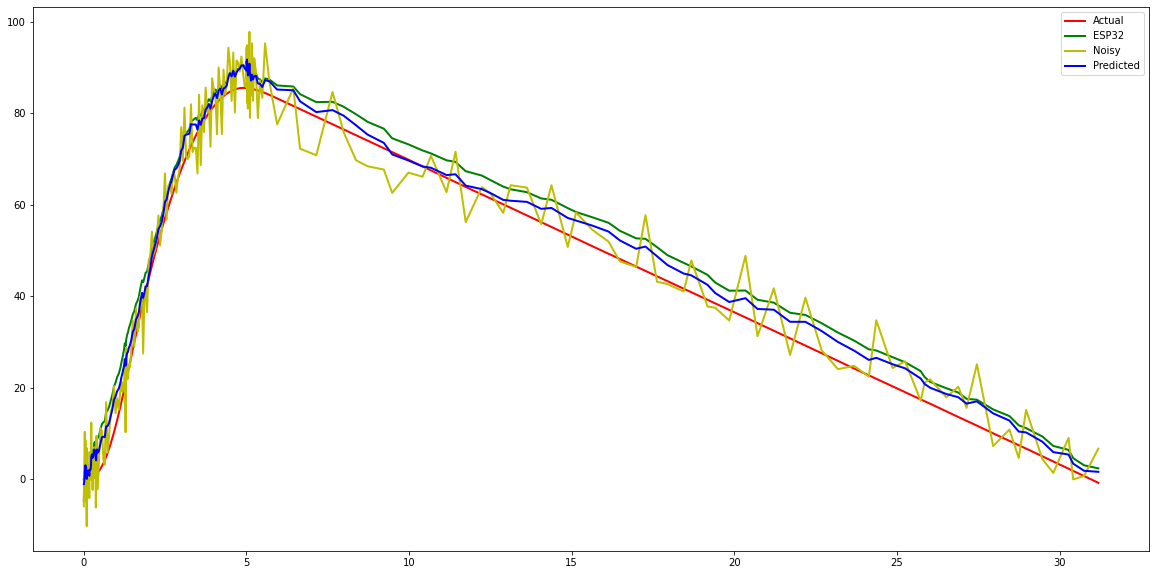

In [18]:
plt.figure(figsize=(20, 10))
plt.plot(noisy_df.Time, df['Altitude'],  linewidth=2, color="r", label="Actual")
plt.plot(noisy_df.Time, current,  linewidth=2, color="g", label="ESP32")
plt.plot(noisy_df.Time, noisy_df['Altitude'],  linewidth=2, color="y", label="Noisy")
plt.plot(noisy_df.Time, y,  linewidth=2, color="b", label="Predicted")
plt.legend()
plt.show()

In [19]:
def kalman_update_return_velocity(param):
    r1, r2, q1 = param['r1'], param['r2'], param['q1']
    R = np.array([[r1, 0.0], [0.0, r2]])
    Q = np.array([[q1, 0.0, 0.0], [0.0, q1, 0.0], [0.0, 0.0, q1]])
    
    A = np.array([[1.0, 0.05, 0.00125], [0, 1.0, 0.05], [0, 0, 1]])
    H = np.array([[1.0, 0.0, 0.0],[ 0.0, 0.0, 1.0]])
    P = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    I = np.identity(3)
    x_hat = np.array([[0.0], [0.0], [0.0]])
    Y = np.array([[0.0], [0.0]])

    new_altitude = []
    new_acceleration = []
    new_velocity = []
    
    for altitude, az in zip(noisy_df['Altitude'], noisy_df['Vertical_acceleration']):
        Z = np.array([[altitude], [az]])

        x_hat_minus = np.dot(A, x_hat)
        P_minus = np.dot(np.dot(A, P), np.transpose(A)) + Q
        K  = np.dot(np.dot(P_minus, np.transpose(H)), np.linalg.inv((np.dot(np.dot(H, P_minus), np.transpose(H)) + R)))
        Y = Z - np.dot(H, x_hat_minus)
        x_hat = x_hat_minus + np.dot(K, Y)
        P = np.dot((I - np.dot(K, H)), P_minus)
        Y = Z - np.dot(H, x_hat_minus)
        new_altitude.append(float(x_hat[0]))
        new_velocity.append(float(x_hat[1]))
        new_acceleration.append(float(x_hat[2]))
    return new_velocity

In [20]:
def objective_function(param):
    r1, r2, q1 = param['r1'], param['r2'], param['q1']
    R = np.array([[r1, 0.0], [0.0, r2]])
    Q = np.array([[q1, 0.0, 0.0], [0.0, q1, 0.0], [0.0, 0.0, q1]])
    
    A = np.array([[1.0, 0.05, 0.00125], [0, 1.0, 0.05], [0, 0, 1]])
    H = np.array([[1.0, 0.0, 0.0],[ 0.0, 0.0, 1.0]])
    P = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
    I = np.identity(3)
    x_hat = np.array([[0.0], [0.0], [0.0]])
    Y = np.array([[0.0], [0.0]])

    new_altitude = []
    new_acceleration = []
    new_velocity = []
    
    for altitude, az in zip(noisy_df['Altitude'], noisy_df['Vertical_acceleration']):
        Z = np.array([[altitude], [az]])

        x_hat_minus = np.dot(A, x_hat)
        P_minus = np.dot(np.dot(A, P), np.transpose(A)) + Q
        K  = np.dot(np.dot(P_minus, np.transpose(H)), np.linalg.inv((np.dot(np.dot(H, P_minus), np.transpose(H)) + R)))
        Y = Z - np.dot(H, x_hat_minus)
        x_hat = x_hat_minus + np.dot(K, Y)
        P = np.dot((I - np.dot(K, H)), P_minus)
        Y = Z - np.dot(H, x_hat_minus)
        new_altitude.append(float(x_hat[0]))
        new_velocity.append(float(x_hat[1]))
        new_acceleration.append(float(x_hat[2]))
    return mean_squared_error(df['Vertical_velocity'], new_velocity)

In [32]:
space = {
    "r1": hp.choice("r1", np.arange(0.001, 90, 0.001)),
    "r2": hp.choice("r2", np.arange(0.001, 90, 0.001)),
    "q1": hp.choice("q1", np.arange(0.00001, 0.09, 0.00001))
}

In [33]:
# Initialize trials object
trials = Trials()

best = fmin(fn=objective_function, space = space, algo=tpe.suggest, max_evals=100, trials=trials )

100%|█████████████████████████████████████████████████████| 100/100 [9:31:10<00:00, 342.70s/trial, best loss: 90.1247837384137]


In [34]:
print(best)
print(space_eval(space, best))

{'q1': 8983, 'r1': 66244, 'r2': 58366}
{'q1': 0.08984, 'r1': 66.245, 'r2': 58.367}


In [35]:
d2 = space_eval(space, best)

In [36]:
objective_function(d2)

90.1247837384137

In [37]:
y = kalman_update_return_velocity(d2)
current = kalman_update_return_velocity({'q1': 0.0013, 'r1': 0.25, 'r2': 0.65})
previous = kalman_update_return_velocity({'q1': 0.08519, 'r1': 4.719, 'r2': 56.443})

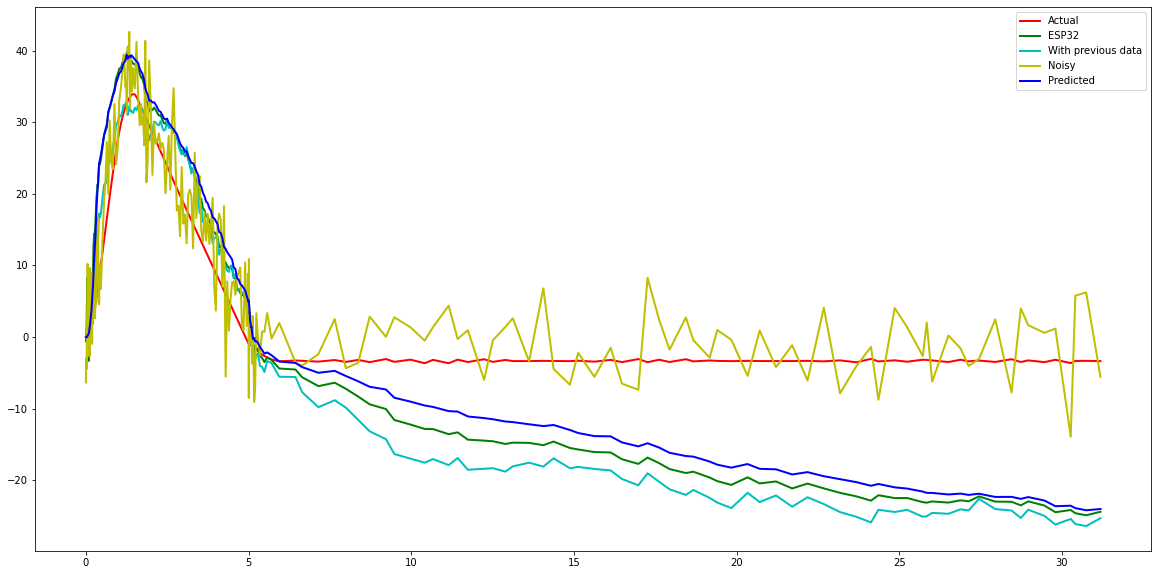

In [38]:
plt.figure(figsize=(20, 10))
plt.plot(noisy_df.Time, df['Vertical_velocity'],  linewidth=2, color="r", label="Actual")
plt.plot(noisy_df.Time, current,  linewidth=2, color="g", label="ESP32")
plt.plot(noisy_df.Time, previous,  linewidth=2, color="c", label="With previous data")
plt.plot(noisy_df.Time, noisy_df['Vertical_velocity'],  linewidth=2, color="y", label="Noisy")
plt.plot(noisy_df.Time, y,  linewidth=2, color="b", label="Predicted")
plt.legend()
plt.show()